In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
from tensorflow import keras
import pandas as pd
from matplotlib import pyplot as plt
from config import Config
import os
import numpy as np
from utils import normalize
from custom import CustomLeakyReLU, CustomClippedReLU

In [5]:
model_path = './models/dl/soc_estimation_dl.keras'
loaded_model = keras.models.load_model(
    model_path, 
    custom_objects={
        'CustomLeakyReLU': CustomLeakyReLU,
        'CustomClippedReLU': CustomClippedReLU
    }
)

In [6]:
config = Config(
    data_dir='./data',
    train_data_subdir='train/',
    val_data_subdir='test/',
    test_data_subdir='test/'
)

data_dir = ['test', 'train', 'val']
train_data_dir = ['TRAIN_LGHG2@n10degC_to_25degC_Norm_5Inputs.csv']
val_data_dir = ['01_TEST_LGHG2@n10degC_Norm_(05_Inputs).csv', '02_TEST_LGHG2@0degC_Norm_(05_Inputs).csv', '03_TEST_LGHG2@10degC_Norm_(05_Inputs).csv', '04_TEST_LGHG2@25degC_Norm_(05_Inputs).csv']
test_data_dir = ['01_TEST_LGHG2@n10degC_Norm_(05_Inputs).csv', '02_TEST_LGHG2@0degC_Norm_(05_Inputs).csv', '03_TEST_LGHG2@10degC_Norm_(05_Inputs).csv', '04_TEST_LGHG2@25degC_Norm_(05_Inputs).csv']


In [7]:
test_data_filename = os.listdir(config.get_test_data_dir())[2]
test_data_path = os.path.join(config.get_test_data_dir(), test_data_filename)
test_data = pd.read_csv(test_data_path)
test_data

,V,I,Temp,V_avg,I_avg,SOC
0,0.968019,0.749112,0.521236,0.968019,0.749112,1.000000
1,0.965316,0.747098,0.521236,0.966668,0.748105,0.999990
2,0.965198,0.746992,0.521236,0.966178,0.747734,0.999983
3,0.964961,0.747098,0.518403,0.965874,0.747575,0.999973
4,0.964961,0.747098,0.518403,0.965691,0.747480,0.999963
...,...,...,...,...,...,...
44279,0.335128,0.751020,0.532568,0.329741,0.751020,0.194990
44280,0.335128,0.751020,0.532568,0.329778,0.751020,0.194990
44281,0.335128,0.751020,0.532568,0.329815,0.751020,0.194990
44282,0.335128,0.751020,0.532568,0.329851,0.751020,0.194990


In [8]:
X_test = test_data[['V', 'I', 'Temp', 'V_avg', 'I_avg']].values
X_test.shape

(44284, 5)

In [9]:
X_test

array([[0.96801895, 0.74911237, 0.52123591, 0.96801895, 0.74911237],
       [0.96531628, 0.7470984 , 0.52123591, 0.96666762, 0.74810539],
       [0.96519787, 0.74699221, 0.52123591, 0.9661777 , 0.74773433],
       ...,
       [0.33512765, 0.75102009, 0.53256776, 0.32981484, 0.75102009],
       [0.33512765, 0.75102009, 0.53256776, 0.32985141, 0.75102009],
       [0.33512765, 0.75102009, 0.53256776, 0.3298875 , 0.75102009]])

In [10]:
normalized_X_test = normalize(X_test)
normalized_X_test

array([[ 1.        ,  0.02007657, -1.        ,  1.        ,  0.02007657],
       [ 0.99393247,  0.01412849, -1.        ,  1.        ,  0.01864986],
       [ 0.99559568,  0.01476778, -1.        ,  1.        ,  0.01810358],
       ...,
       [-0.97477332,  1.        , -0.0372726 , -1.        ,  1.        ],
       [-0.97494477,  1.        , -0.03736266, -1.        ,  1.        ],
       [-0.97511403,  1.        , -0.03745156, -1.        ,  1.        ]])

In [11]:
y_test = test_data['SOC'].values
y_test.shape

(44284,)

In [12]:
y_test

array([1.        , 0.99999   , 0.99998333, ..., 0.19499   , 0.19499   ,
       0.19499   ])

In [13]:
soc_observed = y_test

soc_predicted = loaded_model.predict(normalized_X_test)
soc_predicted

1384/1384 ━━━━━━━━━━━━━━━━━━━━ 3s 814us/step


array([[0.9927086 ],
       [0.99236053],
       [0.9924244 ],
       ...,
       [0.22566238],
       [0.22567153],
       [0.22568065]], dtype=float32)

In [14]:
results = loaded_model.evaluate(normalized_X_test, y_test)
results

1384/1384 ━━━━━━━━━━━━━━━━━━━━ 1s 901us/step - loss: 0.0074


0.00584622984752059

In [15]:
class ErrorFunctions:
    @staticmethod
    def rmse(observed, predicted):
        diff = []
        if len(predicted) != len(observed):
            raise Exception(f'(len(predicted),len(observed))=({len(predicted)},{len(observed)}) => {len(predicted)}!={len(observed)}')
        for i in range(len(predicted)):
            diff_value = predicted[i] - observed[i]
            quad_value = diff_value**2
            diff.append(quad_value)
        return np.sqrt(np.mean(diff))

    @staticmethod
    def max(observed, predicted):
        diff = []
        if len(predicted) != len(observed):
            raise Exception(f'(len(predicted),len(observed))=({len(predicted)},{len(observed)}) => {len(predicted)}!={len(observed)}')
        for i in range(len(predicted)):
            diff_value = predicted[i] - observed[i]
            diff.append(diff_value)
        return np.max(np.abs(diff))

    @staticmethod
    def mae(observed, predicted):
        diff = []
        if len(predicted) != len(observed):
            raise Exception(f'(len(predicted),len(observed))=({len(predicted)},{len(observed)}) => {len(predicted)}!={len(observed)}')
        for i in range(len(predicted)):
            diff_value = predicted[i] - observed[i]
            diff.append(diff_value)
        return np.mean(np.abs(diff))

In [16]:
rmse_value = ErrorFunctions.rmse(soc_observed, soc_predicted)
print(f'rmse(observed, predicted) = {round(rmse_value*100,2)}%')
max_value = ErrorFunctions.max(soc_observed, soc_predicted)
print(f'max(observed, predicted) = {round(max_value*100,2)}%')
mae_value = ErrorFunctions.mae(soc_observed, soc_predicted)
print(f'mae(observed, predicted) = {round(mae_value*100,2)}%')

rmse(observed, predicted) = 7.65%
max(observed, predicted) = 28.64%
mae(observed, predicted) = 5.43%


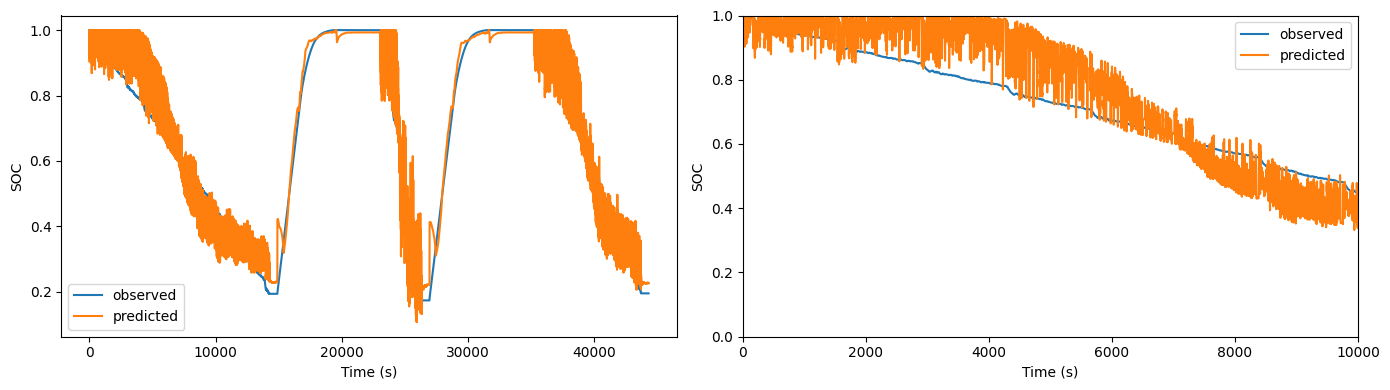

In [26]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

axs[0].plot(soc_observed, label='observed')
axs[0].plot(soc_predicted, label='predicted')
axs[0].set_ylabel('SOC')
axs[0].set_xlabel('Time (s)')
axs[0].legend()

axs[1].plot(soc_observed, label='observed')
axs[1].plot(soc_predicted, label='predicted')
axs[1].set_ylabel('SOC')
axs[1].set_xlabel('Time (s)')
axs[1].legend()
axs[1].axis([0, 10000, 0, 1])

plt.tight_layout()
plt.show()